In [2]:
import numpy as np
import xarray as xr
import os.path as op
import scipy.interpolate as intp
from xmitgcm import open_mdsdataset
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp2d, PchipInterpolator
from matplotlib.colors import from_levels_and_colors as flc
from matplotlib import pyplot as plt
%matplotlib inline

In [1]:
res = 100e0 #km

# set output_directory to save input files. 
output_dir = '/rigel/ocp/users/tu2140/chkp63n/MITgcm/Southern-Ocean/channel_flat/input/'

# set format of binary files 
tp = '>f8'

In [3]:
# function that makes xy grid
def make_grid_xy(nx,ny, lengthx=1.0e6, lengthy=2.0e6):
    lx, ly = lengthx, lengthy
    # nx, ny = n, n
    dx, dy = lx/nx, ly/ny

    # create mesh-grids for cell centers
    xc, yc = np.meshgrid(
                dx * np.arange(nx) + dx/2,
                dy * np.arange(ny) + dy/2)
    
    return xc, yc

In [4]:
# domain width and length (currently using a square)
Ly = 2.0e6
Lx = 1.0e6

# number of center grid points (how many dx fit in the domain)
nx = int(Lx/res/1000)
ny = int(Ly/res/1000)

# generate the x,y grid
xc, yc = make_grid_xy(nx,ny, Lx,Ly)

In [5]:
yc

array([[  1.00000000e+03,   1.00000000e+03,   1.00000000e+03, ...,
          1.00000000e+03,   1.00000000e+03,   1.00000000e+03],
       [  3.00000000e+03,   3.00000000e+03,   3.00000000e+03, ...,
          3.00000000e+03,   3.00000000e+03,   3.00000000e+03],
       [  5.00000000e+03,   5.00000000e+03,   5.00000000e+03, ...,
          5.00000000e+03,   5.00000000e+03,   5.00000000e+03],
       ..., 
       [  1.99500000e+06,   1.99500000e+06,   1.99500000e+06, ...,
          1.99500000e+06,   1.99500000e+06,   1.99500000e+06],
       [  1.99700000e+06,   1.99700000e+06,   1.99700000e+06, ...,
          1.99700000e+06,   1.99700000e+06,   1.99700000e+06],
       [  1.99900000e+06,   1.99900000e+06,   1.99900000e+06, ...,
          1.99900000e+06,   1.99900000e+06,   1.99900000e+06]])

In [5]:
dzhigh = np.array([1.00,    1.14,    1.30,    1.49,   1.70,
                  1.93,    2.20,    2.50,    2.84,   3.21,
                  3.63,    4.10,    4.61,    5.18,   5.79,
                  6.47,    7.20,    7.98,    8.83,   9.73,
                  10.69,   11.70,   12.76,   13.87,  15.03,
                  16.22,   17.45,   18.70,   19.97,  21.27,
                  22.56,   23.87,   25.17,   26.46,  27.74,
                  29.00,   30.24,   31.45,   32.65,  33.82,
                  34.97,   36.09,   37.20,   38.29,  39.37,
                  40.45,   41.53,   42.62,   43.73,  44.87,
                  46.05,   47.28,   48.56,   49.93,  51.38,
                  52.93,   54.61,   56.42,   58.38,  60.53,
                  62.87,   65.43,   68.24,   71.33,  74.73,
                  78.47,   82.61,   87.17,   92.21,  97.79,
                  103.96,  110.79,  118.35,  126.73, 136.01, 174.67])
dzlow = np.append(np.array([10.0, 10.0, 10.0, 12.0, 14.0, 
                  16.0, 19.0, 22.0, 26.0, 30.0, 
                  36.0, 42.0, 50.0, 60.0, 72.0, 85., 102.]), 103.*np.ones(23))
nz = len(dzlow)
nz

40

In [6]:
ddir = '/rigel/ocp/users/tu2140/chkp63n/MITgcm/Southern-Ocean/channel_flat/input/'

# Topographic shape
Large scale shape of topography - flat bottom with gaussian bump

$$ bathy = -H + h_b = -H + h_0 e^{-x^2/\sigma^2} $$

With $H = 2985$ m, $h_0 = 927$ m and $\sigma = 75$ km.
(The particular numbers are chosen to match Ryan's previous experiments, and also work with the vertical grid)

In [7]:
H  = 2985.0
h0 = 0.
sig= 75.0e3

bathy      = -(H - h0*np.exp(-(xc - Lx/2)**2 / sig**2))
bathy[:,:] = -H
bathy[0,:] = 0.0 # create a wall to the south. By default MITgcm assumes periodic in both directions.

In [8]:
print(bathy.shape)
bathy.astype(tp).tofile(output_dir + 'BATHY_flat_bump_deep%03dkm.bin' % res)

(20, 10)


# Wind conditions
We use an atmospheric jet as the wind forcing. This condition diverges slightly from Ryan's previous runs, as generate a jet that is more focussed in the center (change from $sin(y)$ to $sin^2(y)$).

$$ \tau = \tau_0 sin^2(\pi y/L_y) $$

In order to add the binomial seasonality, we change the value of $\tau_0$.

In [9]:
# tau0 = 0.2
ds = xr.open_dataset(op.join(ddir,'SOSE-windstress_monclim-5Dave.nc'))
Stau = ds.tau
Stau

<xarray.DataArray 'tau' (iDinY: 73, iY: 320, iX: 2160)>
[50457600 values with dtype=float32]
Coordinates:
  * iY       (iY) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * iX       (iX) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
    Y        (iY, iX) float64 ...
    X        (iY, iX) float64 ...
  * iDinY    (iDinY) int64 0 1 2 3 4 5 6 7 8 9 ... 63 64 65 66 67 68 69 70 71 72

In [9]:
days = [2.5]
for i in range(1,len(Stau.iDinY)):
    days.append(2.5+i*5)
days

[2.5,
 7.5,
 12.5,
 17.5,
 22.5,
 27.5,
 32.5,
 37.5,
 42.5,
 47.5,
 52.5,
 57.5,
 62.5,
 67.5,
 72.5,
 77.5,
 82.5,
 87.5,
 92.5,
 97.5,
 102.5,
 107.5,
 112.5,
 117.5,
 122.5,
 127.5,
 132.5,
 137.5,
 142.5,
 147.5,
 152.5,
 157.5,
 162.5,
 167.5,
 172.5,
 177.5,
 182.5,
 187.5,
 192.5,
 197.5,
 202.5,
 207.5,
 212.5,
 217.5,
 222.5,
 227.5,
 232.5,
 237.5,
 242.5,
 247.5,
 252.5,
 257.5,
 262.5,
 267.5,
 272.5,
 277.5,
 282.5,
 287.5,
 292.5,
 297.5,
 302.5,
 307.5,
 312.5,
 317.5,
 322.5,
 327.5,
 332.5,
 337.5,
 342.5,
 347.5,
 352.5,
 357.5,
 362.5]

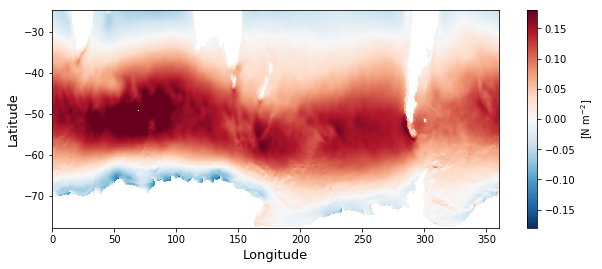

In [60]:
fig, ax = plt.subplots(figsize=(10,4))
# ax.plot(Stau.sel(iY=slice(130,170)).mean(['iY','iX']), 'k', lw=2)
im = ax.pcolormesh(Stau.X, Stau.Y, np.ma.masked_invalid(Stau.mean('iDinY')), 
                  rasterized=True, cmap='RdBu_r',
                  vmin=-.18, vmax=.18)
ax.set_xlabel(r'Longitude', fontsize=13)
ax.set_ylabel(r'Latitude', fontsize=13)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'[N m$^{-2}$]')
plt.savefig('SOSE-windstressclim.pdf')

In [37]:
Stau.sel(iY=slice(131,181)).Y[:,0]

<xarray.DataArray 'Y' (iY: 50)>
array([-56.041634, -55.874966, -55.708298, -55.541634, -55.374966, -55.208298,
       -55.041634, -54.874966, -54.708298, -54.541634, -54.374966, -54.208298,
       -54.041634, -53.874966, -53.708298, -53.541634, -53.374966, -53.208298,
       -53.041634, -52.874966, -52.708298, -52.541634, -52.374966, -52.208298,
       -52.041634, -51.874966, -51.708298, -51.541634, -51.374966, -51.208298,
       -51.041634, -50.874966, -50.708298, -50.541634, -50.374966, -50.208298,
       -50.041634, -49.874966, -49.708298, -49.541634, -49.374966, -49.208298,
       -49.041634, -48.874966, -48.708298, -48.541634, -48.374966, -48.208298,
       -48.041634, -47.874966])
Coordinates:
  * iY       (iY) int64 131 132 133 134 135 136 137 138 139 140 141 142 143 ...
    iX       int64 0
    Y        (iY) float64 ...
    X        (iY) float64 ...

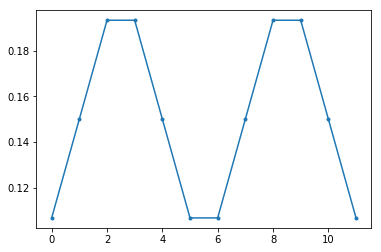

In [6]:
# tau_ideal = 0.15 - 0.05*np.sin(np.pi/3*(np.arange(1,13)+1))
# tau_ideal = np.zeros(24)
# tau_ideal[:2] = 0.1
# tau_ideal[1:6] = np.linspace(.1,.2,5)
# tau_ideal[6:7] = 0.2
# tau_ideal[7:12] = np.linspace(.2,.1,5)
# tau_ideal[12:13] = .1
# tau_ideal[13:18] = np.linspace(.1,.2,5)
# tau_ideal[18:19] = .2
# tau_ideal[19:] = np.linspace(.2,.1,5)
# tau_ideal[23:] = .1
tau_const = 0.15
# tau_ideal = tau_const - 0.05*np.cos(np.pi/90*np.arange(15.,360.,30.))
tau_ideal = tau_const - 0.05*np.cos(np.pi/3*np.arange(0.5,12.5))
# tau_ideal[:15] = tau_ideal[15]
# tau_ideal[-15:] = tau_ideal[-15]
plt.plot(tau_ideal, '.-')

In [13]:
print(tau_ideal[0], tau_ideal[-1])

0.106698729811 0.106698729811


In [7]:
# tau = np.zeros([ny,nx])

# make sure that the wind goes to zero at the north and south boundary within in the domain.
# be careful that one grid point to the south is just land. 
# the way the wind is defined right now, the wavelength changes slightly between runs.
# also make sure that the wind profile looks the same in all the runs with different resolution.

dy = yc[1,1] - yc[0,1]
# tau_realistic = tau0.data[:,np.newaxis,np.newaxis]*(np.sin(np.pi* (yc)/(Ly))**2) # slightly squeezed wind profile to account 
# tau = tau_ideal[:,np.newaxis,np.newaxis]*(np.sin(np.pi* (yc)/(Ly))**2)
a = 100e3 # the narrowness of the 
tau = tau_ideal[:,np.newaxis,np.newaxis]*(np.sin(np.pi*(yc-a/2)/(Ly-a))**2) 
# tau = tau_const*(np.sin(np.pi*(yc-a/2)/(Ly-a))**2)[np.newaxis,:,:] * np.ones(12)[:,np.newaxis,np.newaxis]
tau[:,yc<=a/2] = 0.
tau[:,yc>=(Ly-a/2)] = 0.
# for the presence of land cell at the southern most grid cell.

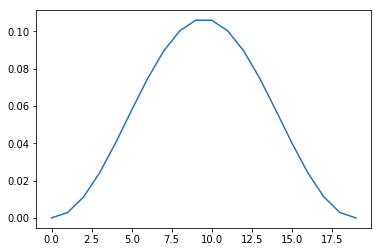

In [8]:
plt.plot(tau[0,:,0])

In [16]:
print(tau[:,:50,0])
print(tau[:,-50:,0])

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


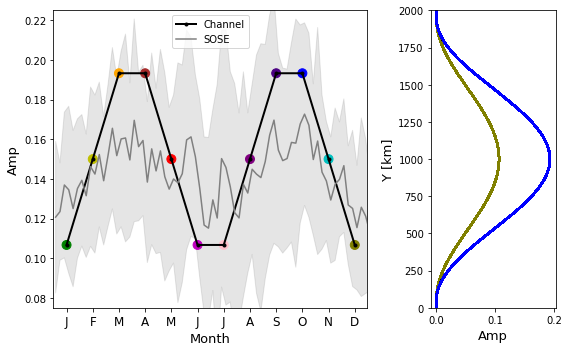

In [21]:
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']

fig = plt.figure(figsize=(8,5))
gs = gridspec.GridSpec(nrows=1,ncols=6)
ax1 = plt.subplot(gs[:,:4])
ax2 = plt.subplot(gs[:,4:])
ax1.plot(range(15,360,30), tau_ideal, 'k.-', lw=2, label=r'Channel')
# ax1.plot(range(0,360,30), tau_const*np.ones(12), 'k', lw=2, label=r'ideal')
ax1.plot(days, Stau.sel(iY=slice(130,170)).mean(['iY','iX']), 
         color='grey', label=r'SOSE')
ax1.fill_between(days, Stau.sel(iY=slice(130,170)).mean(['iY','iX'])-Stau.sel(iY=slice(130,170)).std(['iY','iX']),
                 Stau.sel(iY=slice(130,170)).mean(['iY','iX'])+Stau.sel(iY=slice(130,170)).std(['iY','iX']),
                 color='grey', alpha=0.2)
ax1.scatter(range(15,375,30),tau_ideal,color=colors,s=80)
# ax1.scatter(range(1,13),tau_const*np.ones(12),color=colors,s=80)
ax1.set_xlim([0,359])
ax1.set_ylim([0.075,0.225])
ax1.set_xticks(range(15,360,30))
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'], fontsize=12)
ax1.set_xlabel('Month', fontsize=13)
ax1.set_ylabel('Amp', fontsize=13)
# for i in range(12):
#     ax2.plot(tau[:,:,0][i],yc*1e-3,c=colors[i])
ax2.plot(tau[:,:,0][-1],yc*1e-3,c=colors[-1], lw=2)
ax2.plot(tau[:,:,0][-3],yc*1e-3,c=colors[-3], lw=2)
ax2.set_xlabel('Amp', fontsize=13)
ax2.set_ylabel(r'Y [km]', fontsize=13)
# ax2.set_xlim([0,.2])
ax2.set_ylim([0,2e3])
ax1.legend(loc='upper center')
plt.tight_layout()
plt.savefig('SurfaceTau-sin2_seasonality_sinusoid.pdf')

In [13]:
tau.shape

(12, 20, 10)

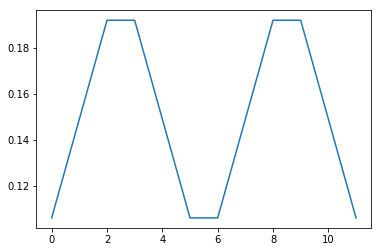

In [15]:
plt.plot(tau[:,10,0])

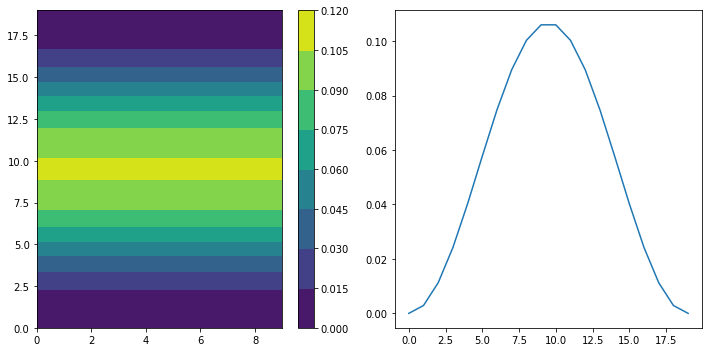

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(tau[0])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(tau[0,:,0],'-')
plt.tight_layout()

In [16]:
print(tau.shape)
fname = output_dir + 'TAU-sin2_seasonal_50km0pad_%03dkm.bin' % res
print(fname)
tau.astype(tp).tofile(fname)
# tau_realistic.astype(tp).tofile((output_dir + 'TAU-sin2_seasonal_%03dkm.bin'%res))

(12, 20, 10)
/rigel/ocp/users/tu2140/chkp63n/MITgcm/Southern-Ocean/channel_flat/input/TAU-sin2_seasonal_50km0pad_100km.bin


# Surface buoyancy conditions
Restore the surface to a linear buoyancy profile (temperature as there is no salt in the simulation)

$$ T(y) = T_0 (y/L_y) $$

where $T_0$ is also changed to incorporate seasonality.

In [10]:
# Tmin, Tmax = 0., 8.0
# Tvar = xr.open_dataarray(op.join(ddir,'theta-surface-seasonality_SOSE.nc'))
# ds = xr.open_dataset(op.join(ddir, 'BSOSE-SST_40-65S_100-140E_rot-8.nc'))
# Bsst = ds.SST
# sst_n = np.roll(1.*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+8.0,1)
# sst_s = np.roll(1.*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+0.,1)
# sst_1 = np.roll(1.75*np.cos(np.roll(np.arange(0.,2*np.pi,2*np.pi/12.),-2))+3.25,2)
# sst_2 = np.roll(1.75*np.cos(np.roll(np.arange(0.,2*np.pi,2*np.pi/12.),-2))+4.75,2)
sst_1 = 1.75*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+3.25
sst_2 = 1.75*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+4.75
# sst_tf = np.roll(0.05*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+9.45,1)
# slopes = np.roll(1*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+7,7)/2e2
# slopen = np.roll(3.5*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+6.5,1)/2e2
# print(sst_n,sst_s):q


# plt.plot(range(1,13),sst_n-10.01,'r')
# plt.plot(range(1,13),sst_s-0.,'b')
# plt.plot(np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+9, 'k-.')
# plt.plot(np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+9, 'k--')
# sst[:,20:120].plot()

In [18]:
Bsst

<xarray.DataArray 'SST' (month: 12, iY: 128)>
array([[  0.518073,   0.640364,   0.707239, ...,  14.37598 ,  14.511768,
         14.660532],
       [  0.852468,   0.932821,   0.963917, ...,  15.16413 ,  15.301361,
         15.443094],
       [ -0.183879,  -0.094902,  -0.018267, ...,  14.95244 ,  15.081324,
         15.221977],
       ..., 
       [ -1.759136,  -1.754913,  -1.753749, ...,  11.263532,  11.412636,
         11.533062],
       [ -1.727509,  -1.726891,  -1.729632, ...,  12.370112,  12.532794,
         12.675294],
       [ -1.027517,  -0.983478,  -0.947142, ...,  13.46729 ,  13.639163,
         13.81324 ]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * iY       (iY) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...

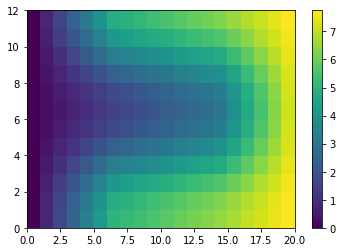

In [11]:
# sst = sst_n[:,np.newaxis]-.1 + np.linspace(-10.,0.,num=ny)[np.newaxis,:]

sst = np.zeros((12,ny))
heat = int(.3*ny) 
cool = int(.7*ny)
for i in range(12):
    sst[i,:heat+1] = np.linspace(0.,sst_1[i],heat+1)
    sst[i,heat:cool+1] = np.linspace(sst_1[i],sst_2[i],cool-heat+1)
    sst[i,cool:] = np.linspace(sst_2[i],8.,ny-cool,endpoint=False)

# sst_lin = sst.copy()
# sst[:,125:166] += np.linspace(0,-1.25,num=41)
# sst[:,166:176] += np.linspace(-1.25,0,num=11)[1:]

fig, ax = plt.subplots()
cax = ax.pcolormesh(sst)
fig.colorbar(cax)

In [12]:
print(np.diff(sst[0]))

[ 0.04166667  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667
  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667
  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667
  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667
  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667
  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667
  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667
  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667
  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667
  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667
  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667
  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667
  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667  0.04166667
  0.04166667  0.04166667  0.04166667  0.04166667  0

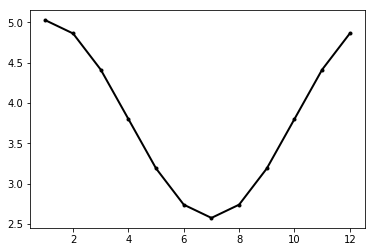

In [12]:
plt.plot(range(1,13), sst.mean(axis=-1), 'k.-', lw=2)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


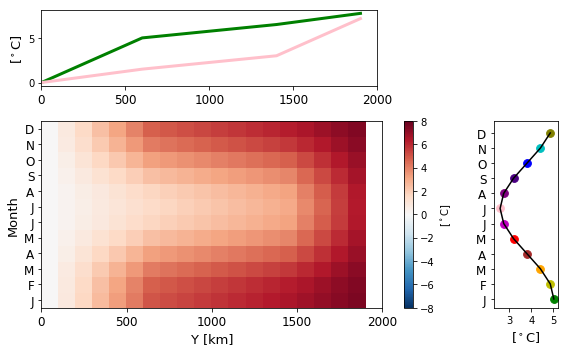

In [13]:
mon = ['J','F','M','A','M','J','J','A','S','O','N','D']
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']
# colors = ['m','olive','g','c','b','indigo','purple','brown','orange','y','pink','r']
fig = plt.figure(figsize=(8,5))
fig.set_tight_layout(True)

ax1 = plt.subplot2grid((6,6),(0,0),colspan=4,rowspan=2)
ax2 = plt.subplot2grid((6,6),(2,0),rowspan=4,colspan=5)
ax3 = plt.subplot2grid((6,6),(2,5),rowspan=4)

ax1.plot(np.arange(0,2000,res), sst[0], color=colors[0], lw=3)
ax1.plot(np.arange(0,2000,res), sst[6], color=colors[6], lw=3)
for i in range(12):
    ax3.scatter(sst.mean(axis=-1)[i], np.arange(1,13)[i], s=60., c=colors[i])
ax1.set_xlim([0.,2e3-res])
# ax1.plot(range(200),5.05*np.ones(200), 'k--')
# ax1.plot(range(200),8.*np.ones(200), 'k--')
ax1.set_ylabel(r'[$^\circ$C]', fontsize=13)
# ax1.set_xticklabels([])
im = ax2.pcolormesh(np.arange(0,2000,res), np.arange(13), sst[:], 
                   vmax=8e0, vmin=-8., cmap='RdBu_r', rasterized=True)
ax1.set_xlim([0.,2e3])
ax2.set_xlim([0.,2e3])
ax1.set_xticks(np.array([0,500,1000,1500,2000]))
ax1.set_xticklabels(np.array([0,500,1000,1500,2000]), fontsize=12)
ax2.set_xticks(np.array([0,500,1000,1500,2000]))
ax2.set_xticklabels(np.array([0,500,1000,1500,2000]), fontsize=12)
ax2.set_yticks(np.arange(.5,12.5))
ax2.set_yticklabels(mon, fontsize=12)
ax2.set_ylabel(r"Month", fontsize=13)
ax2.set_xlabel(r"Y [km]", fontsize=13)
ax3.plot(sst.mean(axis=-1), range(1,13), 'k')
ax3.set_xlabel(r'[$^\circ$C]', fontsize=13)
# ax3.set_ylim([1,12])
ax3.set_yticks(range(1,13))
ax3.set_yticklabels(mon, fontsize=12)

cbar = fig.colorbar(im, ax=ax2)
cbar.set_label(r'[$^\circ$C]')

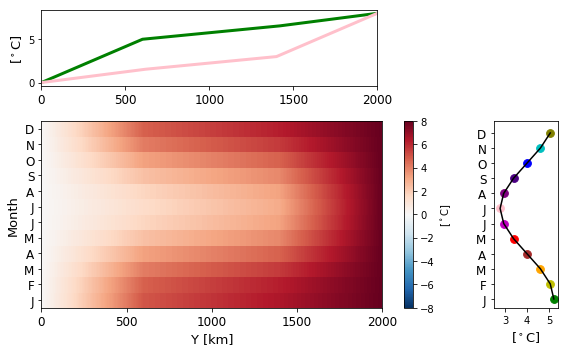

In [20]:
mon = ['J','F','M','A','M','J','J','A','S','O','N','D']
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']
# colors = ['m','olive','g','c','b','indigo','purple','brown','orange','y','pink','r']
fig = plt.figure(figsize=(8,5))
fig.set_tight_layout(True)

ax1 = plt.subplot2grid((6,6),(0,0),colspan=4,rowspan=2)
ax2 = plt.subplot2grid((6,6),(2,0),rowspan=4,colspan=5)
ax3 = plt.subplot2grid((6,6),(2,5),rowspan=4)

ax1.plot(np.arange(0,2000,res), sst[0], color=colors[0], lw=3)
ax1.plot(np.arange(0,2000,res), sst[6], color=colors[6], lw=3)
for i in range(12):
    ax3.scatter(sst.mean(axis=-1)[i], np.arange(1,13)[i], s=60., c=colors[i])
ax1.set_xlim([0.,2e3-res])
# ax1.plot(range(200),5.05*np.ones(200), 'k--')
# ax1.plot(range(200),8.*np.ones(200), 'k--')
ax1.set_ylabel(r'[$^\circ$C]', fontsize=13)
# ax1.set_xticklabels([])
im = ax2.pcolormesh(np.arange(0,2000,res), np.arange(13), sst[:], 
                   vmax=8e0, vmin=-8., cmap='RdBu_r', rasterized=True)
ax1.set_xlim([0.,2e3])
ax2.set_xlim([0.,2e3])
ax1.set_xticks(np.array([0,500,1000,1500,2000]))
ax1.set_xticklabels(np.array([0,500,1000,1500,2000]), fontsize=12)
ax2.set_xticks(np.array([0,500,1000,1500,2000]))
ax2.set_xticklabels(np.array([0,500,1000,1500,2000]), fontsize=12)
ax2.set_yticks(np.arange(.5,12.5))
ax2.set_yticklabels(mon, fontsize=12)
ax2.set_ylabel(r"Month", fontsize=13)
ax2.set_xlabel(r"Y [km]", fontsize=13)
ax3.plot(sst.mean(axis=-1), range(1,13), 'k')
ax3.set_xlabel(r'[$^\circ$C]', fontsize=13)
# ax3.set_ylim([1,12])
ax3.set_yticks(range(1,13))
ax3.set_yticklabels(mon, fontsize=12)

cbar = fig.colorbar(im, ax=ax2)
cbar.set_label(r'[$^\circ$C]')

plt.savefig('SSTforcing_zero-res_-2mon.pdf')

In [37]:
90*86400
8/(2000*1e3)
2*10/(90*86400 * 8/(2000*1e3))

0.6430041152263375

In [133]:
print(np.diff(sst[1]))
print(sst[1])
# print(sst[:,-1]-sst[:,0])
# print(sst[:,-1])
# print(sst_n)

[ 0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02
  0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02
  0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02
  0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02   0.02
  0.02   0.02   0.02   0.02   0.02   0.02   0.11   0.11   0.11   0.11   0.11
  0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11
  0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11
  0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11
  0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11   0.11
  0.11   0.036  0.036  0.036  0.036  0.036  0.036  0.036  0.036  0.036
  0.036  0.036  0.036  0.036  0.036  0.036  0.036  0.036  0.036  0.036
  0.036  0.036  0.036  0.036  0.036  0.036  0.036  0.036  0.036  0.036
  0.036  0.036  0.036  0.036  0.036  0.036  0.036  0.036  0.036  0.036
  0.036  0.036  0.036  

NameError: name 'tau_ideal' is not defined

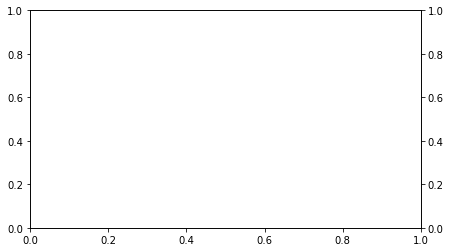

In [111]:
fig, ax = plt.subplots(figsize=(7,4))
ax2 = ax.twinx()
ax.plot(range(1,13),tau_ideal, 'b', lw=2)
ax.scatter(range(1,13),tau_ideal,color='b',s=40)
ax2.plot(range(1,13),sst[:,0], 'r', lw=2)
ax2.scatter(range(1,13),sst[:,0],color='r',s=40)
ax.set_xticks(range(1,13))
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax.set_xlabel('Month', fontsize=13)
ax.set_ylabel('Wind stress', fontsize=13)
ax2.set_ylabel('Southern SST relaxation', fontsize=13)
ax.tick_params('y', colors='b')
ax2.tick_params('y', colors='r')
plt.tight_layout()
plt.savefig('Tau_SouthSSTrelax.pdf')

/rigel/home/tu2140/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


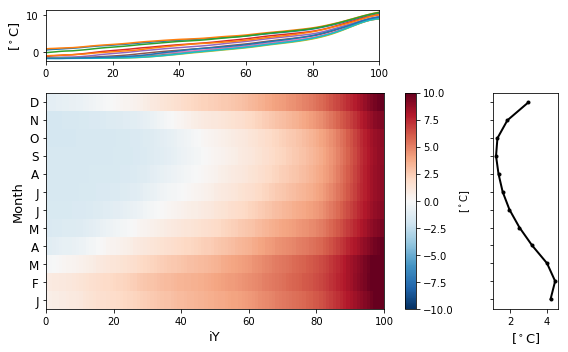

In [67]:
mon = ['J','F','M','A','M','J','J','A','S','O','N','D']
fig = plt.figure(figsize=(8,5))
fig.set_tight_layout(True)

ax1 = plt.subplot2grid((4,6),(0,0),colspan=4)
ax2 = plt.subplot2grid((4,6),(1,0),rowspan=3,colspan=5)
ax3 = plt.subplot2grid((4,6),(1,5),rowspan=3)

for i in range(12):
    ax1.plot(Bsst.sel(iY=slice(None,100)).iY, Bsst.sel(iY=slice(None,100))[i])
ax1.set_xlim([Bsst.sel(iY=slice(None,100)).iY.min(),
              Bsst.sel(iY=slice(None,100)).iY.max()])
ax1.set_ylabel(r'[$^\circ$C]', fontsize=13)
# ax1.set_xticklabels([])
im = ax2.pcolormesh(Bsst.sel(iY=slice(None,100)).iY, np.arange(13), Bsst.sel(iY=slice(None,100)), 
                   vmax=1e1, vmin=-1e1, cmap='RdBu_r', rasterized=True)
ax2.set_yticks(np.arange(.5,12.5,1))
ax2.set_yticklabels(mon, fontsize=12)
ax2.set_ylabel(r"Month", fontsize=13)
ax2.set_xlabel(r"iY", fontsize=13)
ax3.plot(Bsst.sel(iY=slice(None,100)).mean('iY'), range(1,13), 'k.-', lw=2)
ax3.set_xlabel(r'[$^\circ$C]', fontsize=13)
# ax3.set_ylim([1,12])
ax3.set_yticks(range(1,13))
ax3.set_yticklabels([])

cbar = fig.colorbar(im, ax=ax2)
cbar.set_label(r'[$^\circ$C]')

In [8]:
# Tmin, Tmax = 0., 8.0
# Tsurf = (Tmax-Tmin)*yc/Ly

Tsurf = np.zeros((12,200,100))
for i in range(12):
    f = intp.interp1d(np.arange(100), sst[i,20:120].data, fill_value='extrapolate')
    Tsurf[i] = f(np.arange(0,100,.5))[:,np.newaxis] * np.ones(100)

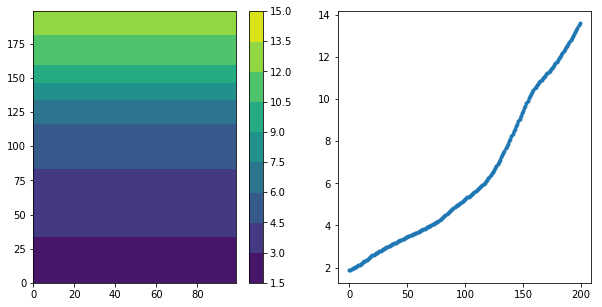

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(Tsurf[0])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(Tsurf[0,:,0],'.-')

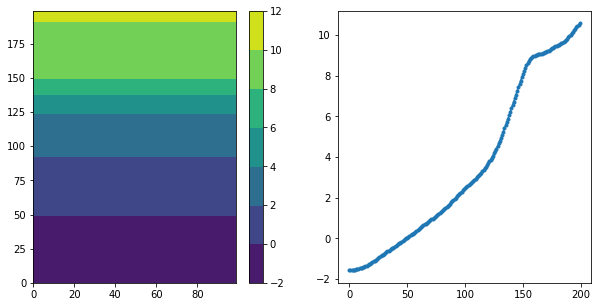

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(Tsurf[7])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(Tsurf[7,:,0],'.-')

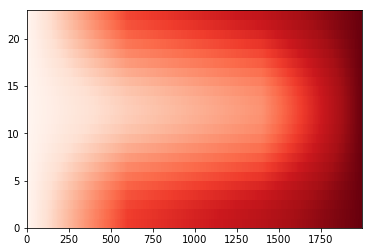

In [48]:
plt.pcolormesh(np.arange(0,2000,res), np.arange(24), sst[:], 
                vmax=8e0, cmap='Reds', rasterized=True)

# CAREFUL WITH WHAT YOU SAVE!!!!
Due to having constant SST runs for the 5km run, I screwed it up in the past.

(12, 20, 10)


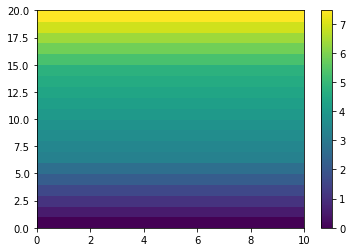

In [19]:
# plt.plot(np.arange(0,2000,res), sst.mean(axis=0))
plt.pcolormesh(((sst.mean(axis=0)[np.newaxis,:]*np.ones(12)[:,np.newaxis])[:,:,np.newaxis] 
              * np.ones(nx)[np.newaxis,np.newaxis,:])[0])
plt.colorbar()
# print(((sst.mean(axis=0)[np.newaxis,:]*np.ones(12)[:,np.newaxis])[:,:,np.newaxis] 
#       * np.ones(nx)[np.newaxis,np.newaxis,:]).shape
#      )

sstsave = sst[:,:,np.newaxis] * np.ones(nx)[np.newaxis,np.newaxis,:]
print(sstsave.shape)
sstsave.astype(tp).tofile((output_dir + 'SST_zerores_rolled_%03dkm.bin' % res))
# (sst_lin[:,:,np.newaxis]*np.ones(nx)[np.newaxis,np.newaxis,:]).astype(tp).tofile((output_dir 
#                                                                                   + 'SST_largegrad-linear_%03dkm.bin' 
#                                                                                   %res))

# PAR condition

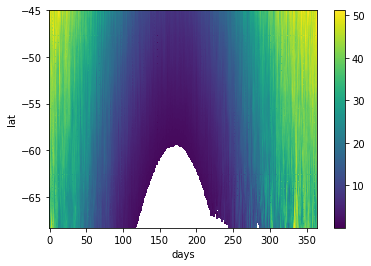

In [20]:
PARvar = xr.open_dataarray(op.join(ddir,'PAR_45-65_SeaWiFS.nc'))
PARvar[:,20:].plot(x='days',y='lat')

In [23]:
PARvar

<xarray.DataArray (days: 365, lat: 300)>
[109500 values with dtype=float64]
Coordinates:
  * days     (days) int64 0 1 2 3 4 5 6 7 8 ... 357 358 359 360 361 362 363 364
  * lat      (lat) float64 -43.38 -43.46 -43.54 -43.63 ... -68.13 -68.21 -68.29

In [21]:
PAR_mon = np.zeros((12,300))
mon_days = {'Jan':range(31),'Feb':range(31,59),'Mar':range(59,90),'Apr':range(90,120),'May':range(120,151),
           'Jun':range(151,181),'Jul':range(181,212),'Aug':range(212,243),'Sep':range(243,273),'Oct':range(273,304),
           'Nov':range(304,334),'Dec':range(334,365)}
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
i = 0
for month in months:
    PAR_mon[i] = np.nanmean(PARvar[mon_days[month][0]:mon_days[month][-1]], axis=0)
    i += 1

PAR_mon = xr.DataArray(PAR_mon, dims=['month','lat'],
                       coords={'month':range(1,13), 'lat':PARvar.lat.data}
                      )

/rigel/home/tu2140/miniconda3/envs/pangeo/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


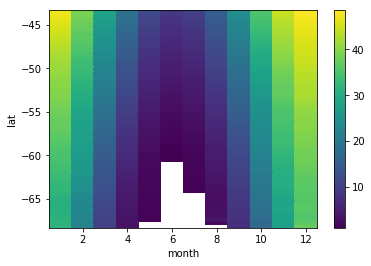

In [22]:
PAR_mon.plot(x='month',y='lat')

In [23]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [24]:
for i in range(12):
    nans, x = nan_helper(PAR_mon[i].data)
    PAR_mon[i,nans] = np.interp(x(nans), x(~nans), PAR_mon.data[i,~nans])

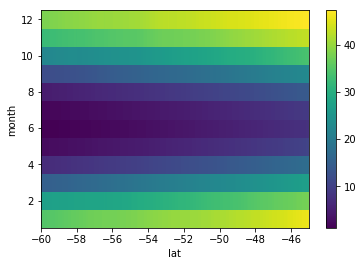

In [25]:
PAR_mon.sel(lat=slice(-45.,-60.)).plot()

<xarray.DataArray ()>
array(-9.835537)


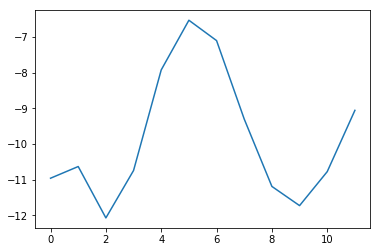

In [26]:
dPAR = PAR_mon.sel(lat=slice(-45.,-60.))[:,-1]-PAR_mon.sel(lat=slice(-45.,-60.))[:,0]
print(dPAR.mean())
plt.plot(dPAR)

In [27]:
par_mid = PAR_mon.sel(lat=slice(-45.,-60.)).mean('lat')
func = PchipInterpolator(np.arange(0,14), 
                      np.append(par_mid[-1].values, np.append(par_mid.values, par_mid[0].values)))
par_north = func(np.arange(1,13))+4.5
# par_north = 3e1+2e1*np.cos(np.pi/12*np.arange(1,25))
par_ideal = par_north[:,np.newaxis] + np.linspace(-9.,0,num=ny)[np.newaxis,:]
par_ideal[par_ideal<0.] = 0.
par_ideal.shape

(12, 20)

In [18]:
par_north-4.5

array([ 39.94026195,  31.49179559,  20.81454473,  11.66892653,
         6.00544675,   4.00962287,   4.87619743,   8.98111115,
        16.99180079,  27.22185828,  37.3540075 ,  42.49711196])

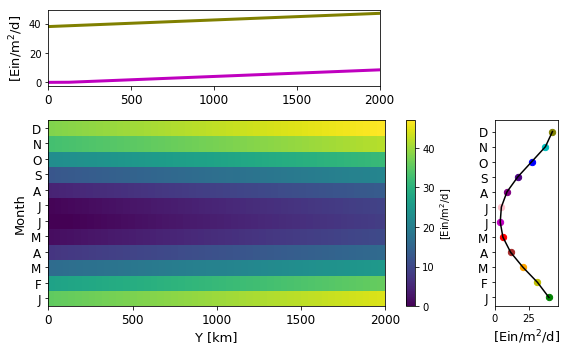

In [29]:
mon = ['J','F','M','A','M','J','J','A','S','O','N','D']
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']

fig = plt.figure(figsize=(8,5))
gs = gridspec.GridSpec(nrows=3,ncols=6)
ax1 = plt.subplot(gs[0,:4])
ax2 = plt.subplot(gs[1:,:5])
ax3 = plt.subplot(gs[1:,5:])

ax1.plot(np.arange(0,2000,res),par_ideal[5],color=colors[5], lw=3)
ax1.plot(np.arange(0,2000,res),par_ideal[-1],color=colors[-1], lw=3)
for i in range(12):
    ax3.scatter(par_ideal.mean(axis=-1)[i], np.arange(1,13)[i], s=40., c=colors[i])
ax1.set_ylabel(r'[Ein/m$^2$/d]', fontsize=13)
ax1.set_xlim([0.,2e3])
ax2.set_xlim([0.,2e3])
ax1.set_xticks(np.array([0,500,1000,1500,2000]))
ax1.set_xticklabels(np.array([0,500,1000,1500,2000]), fontsize=12)
ax2.set_xticks(np.array([0,500,1000,1500,2000]))
ax2.set_xticklabels(np.array([0,500,1000,1500,2000]), fontsize=12)
im = ax2.pcolormesh(np.arange(0,2000,res), range(0,13), par_ideal)
ax2.set_yticks(np.arange(.5,12.5))
ax2.set_yticklabels(mon, fontsize=12)
ax2.set_xlabel(r'Y [km]', fontsize=13)
ax2.set_ylabel(r'Month', fontsize=13)
ax3.plot(par_ideal.mean(axis=-1), 
         np.arange(1,13), 'k')
ax3.set_xlabel(r'[Ein/m$^2$/d]', fontsize=13)
ax3.set_yticks(range(1,13))
ax3.set_yticklabels(mon, fontsize=12)
cbar = fig.colorbar(im, ax=ax2)
cbar.set_label(r'[Ein/m$^2$/d]')
plt.tight_layout()
plt.savefig('PAR-ideal_seasonality.pdf')

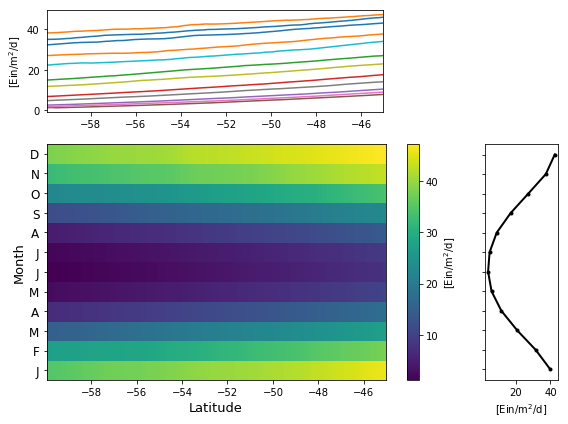

In [25]:
mon = ['J','F','M','A','M','J','J','A','S','O','N','D']

fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(nrows=3,ncols=6)
ax1 = plt.subplot(gs[0,:4])
ax2 = plt.subplot(gs[1:,:5])
ax3 = plt.subplot(gs[1:,5:])
for i in range(12):
    ax1.plot(PAR_mon.sel(lat=slice(-45.,-60.)).lat,PAR_mon.sel(lat=slice(-45.,-60.))[i])
ax1.set_ylabel(r'[Ein/m$^2$/d]')
ax1.set_xlim([PAR_mon.sel(lat=slice(-45.,-60.)).lat.min(),
              PAR_mon.sel(lat=slice(-45.,-60.)).lat.max()])
# ax1.set_xlabel([])
im = ax2.pcolormesh(PAR_mon.sel(lat=slice(-45.,-60.)).lat, range(13), PAR_mon.sel(lat=slice(-45.,-60.)), 
                    rasterized=True)
ax2.set_yticks(np.arange(.5,12.5,1))
ax2.set_yticklabels(mon, fontsize=12)
ax2.set_xlabel(r'Latitude', fontsize=13)
ax2.set_ylabel(r'Month', fontsize=13)
ax3.plot(PAR_mon.sel(lat=slice(-45.,-60.)).mean('lat'), 
         range(1,13), 'k.-', lw=2)
ax3.set_xlabel(r'[Ein/m$^2$/d]')
ax3.set_yticks(range(1,13))
ax3.set_yticklabels([])
cbar = fig.colorbar(im, ax=ax2)
cbar.set_label(r'[Ein/m$^2$/d]')
plt.tight_layout()
# plt.savefig('PAR-SeaWiFS_seasonality.pdf')

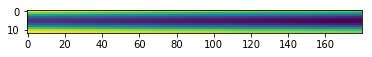

In [35]:
plt.imshow(PAR_mon.sel(lat=slice(-45.,-60.)).data)

In [32]:
PAR_mon.sel(lat=slice(-45.,-60.))

<xarray.DataArray (month: 12, lat: 180)>
array([[ 45.898347,  45.831076,  45.714652, ...,  34.999574,  34.988059,
         34.935979],
       [ 37.667248,  37.550736,  37.483492, ...,  27.049212,  27.063788,
         27.032973],
       [ 26.983407,  26.885225,  26.849725, ...,  15.0639  ,  14.984814,
         14.906311],
       ..., 
       [ 33.973304,  33.909159,  33.834854, ...,  22.394544,  22.318544,
         22.241424],
       [ 43.021811,  42.967677,  42.865669, ...,  32.375318,  32.304694,
         32.244368],
       [ 47.22691 ,  47.165099,  47.131571, ...,  38.217194,  38.206489,
         38.170315]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 -45.04 -45.13 -45.21 -45.29 -45.38 -45.46 -45.54 ...

In [37]:
PAR = np.zeros((12,400,200))
for i in range(12):
    f = intp.interp1d(np.arange(180), np.flipud(PAR_mon.sel(lat=slice(-45.,-60.))[i].data), fill_value='extrapolate')
    PAR[i] = f(np.arange(0,180,180*5e-3))[:,np.newaxis] * np.ones(200)

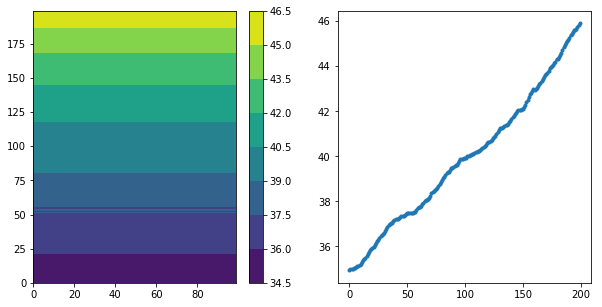

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(PAR[0])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(PAR[0,:,0],'.-')

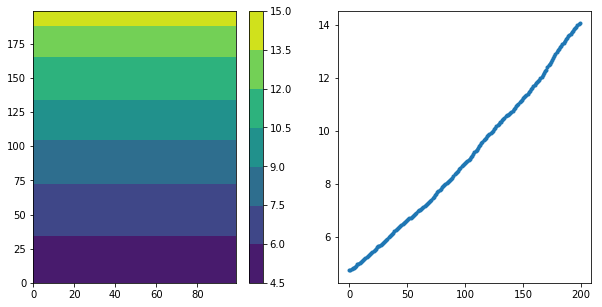

In [40]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(PAR[7])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(PAR[7,:,0],'.-')

In [28]:
print((par_ideal[:,:,np.newaxis]*np.ones(nx)[np.newaxis,np.newaxis,:]).shape)
(par_ideal[:,:,np.newaxis]*np.ones(nx)[np.newaxis,np.newaxis,:]).astype(tp).tofile(output_dir 
                                                                                   + 'PAR_noncos_linear_%03dkm.bin' 
                                                                                   % res)

(12, 20, 10)


# Interpolate the initial conditions on stratification
Currently just using the ones from the old runs by Ryan. However the exact intial condition shouldn't be significant.

In [30]:
# zaxis = np.array([-5. ,   -15. ,   -25. ,   -36. ,   -49. ,   -64. ,   -81.5,
#                 -102. ,  -126. ,  -154. ,  -187. ,  -226. ,  -272. ,  -327. ,
#                 -393. ,  -471.5,  -565. ,  -667.5,  -770.5,  -873.5,  -976.5,
#                -1079.5, -1182.5, -1285.5, -1388.5, -1491.5, -1594.5, -1697.5,
#                -1800.5, -1903.5, -2006.5, -2109.5, -2212.5, -2315.5, -2418.5,
#                -2521.5, -2624.5, -2727.5, -2830.5, -2933.5])
zaxis = np.zeros(nz)
zaxis[0]= -.5
zaxis[1:] = -0.5-np.cumsum(dzlow[:-1])
zaxis

array([-5.0000e-01, -1.0500e+01, -2.0500e+01, -3.0500e+01, -4.2500e+01,
       -5.6500e+01, -7.2500e+01, -9.1500e+01, -1.1350e+02, -1.3950e+02,
       -1.6950e+02, -2.0550e+02, -2.4750e+02, -2.9750e+02, -3.5750e+02,
       -4.2950e+02, -5.1450e+02, -6.1650e+02, -7.1950e+02, -8.2250e+02,
       -9.2550e+02, -1.0285e+03, -1.1315e+03, -1.2345e+03, -1.3375e+03,
       -1.4405e+03, -1.5435e+03, -1.6465e+03, -1.7495e+03, -1.8525e+03,
       -1.9555e+03, -2.0585e+03, -2.1615e+03, -2.2645e+03, -2.3675e+03,
       -2.4705e+03, -2.5735e+03, -2.6765e+03, -2.7795e+03, -2.8825e+03])

In [33]:
np.linspace(-3e2,-3e3,num=10)

array([ -300.,  -600.,  -900., -1200., -1500., -1800., -2100., -2400.,
       -2700., -3000.])

In [34]:
dtype = '>f8'
shape = (12,200,100)
sst = np.fromfile(op.join(ddir, 'SST_change-of-slope_010km.bin'), 
                           dtype=dtype)
sst.shape = shape
print(sst[:,-1,0],sst[:,0,0])

[ 11.79806043  12.064       11.79806043  11.0715      10.079        9.0865
   8.35993957   8.094        8.35993957   9.0865      10.079       11.0715    ] [  1.73205081e+00   2.00000000e+00   1.73205081e+00   1.00000000e+00
   1.22464680e-16  -1.00000000e+00  -1.73205081e+00  -2.00000000e+00
  -1.73205081e+00  -1.00000000e+00  -3.67394040e-16   1.00000000e+00]


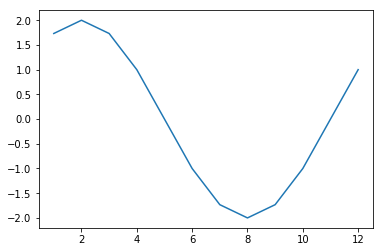

In [35]:
plt.plot(range(1,13),sst[:,0,0])

In [39]:
# delT = 8.0 
# h = 1000. 
# Hmax = 2985.0

# # Use expression (2) from Abernathey et al 2011
# Tstar = delT*(np.exp(zaxis/h) - np.exp(-Hmax/h))/(1-  np.exp(-Hmax/h))

# #plt.plot(temp_relax_large[:,200,0] , zaxis)
# plt.plot(Tstar, zaxis) 
# # There is slight difference from the profile in the paper. 
# # so we will use the analytical expression
a = -145**-1*np.log(5/sst[:,-1])
top = 9
temp_north = np.zeros((12,len(zaxis)))
temp_north[:,:top] = sst[:,-1][:,np.newaxis] * np.exp(a[:,np.newaxis]*(zaxis[:top]+5.))
temp_north[:,top:17] = .1/450.*zaxis[top:17] + 5.1 + 150*.1/450.
temp_north[:,17:25] = 4e2**-1*zaxis[17:25] + 5 + 1.5
temp_north[:,25:] = 5.*np.exp(-16e2**-1*np.log(.2) * (zaxis[25:]+1400)) - 2.
# 
# temp_north[:,top:17] = .1/411.*zaxis[top:17] + 5.1+154*.1/317.5
# temp_north[:,16:25] = 2./823.5*zaxis[16:25] + 5.+zaxis[16]*2./823.5
# temp_north[:,24:] = 4./1545*zaxis[24:] + 3.+zaxis[24]*4./1545
# temp_north[:,0] = sst[:,-1]
# # Nov
# # temp_north[-2,:2] = temp_north[-2,0]
# # a = (temp_north[-2,1]-temp_north[-2,7])/(zaxis[1]-zaxis[7])
# # b = temp_north[-2,1] - a*zaxis[1]
# # temp_north[-2,2:7] = a*zaxis[2:7] + b
# # Nov & Dec
# temp_north[-2:,:3] = temp_north[-2:,0][:,np.newaxis]
# a = (temp_north[-2:,2]-temp_north[-2:,top])/(zaxis[2]-zaxis[top])
# b = temp_north[-2:,2] - a*zaxis[2]
# temp_north[-2:,3:top] = a[:,np.newaxis]*zaxis[3:top][np.newaxis,:] + b[:,np.newaxis]
# # Jan - Mar
# for i in range(3):
#     if i < 2:
#         temp_north[i,:3] = temp_north[i,0]
#         a = (temp_north[i,2]-temp_north[i,top])/(zaxis[2]-zaxis[top])
#         b = temp_north[i,2] - a*zaxis[2]
#         temp_north[i,3:top] = a*zaxis[3:top] + b
#     else:
#         temp_north[i,:5] = temp_north[i,0]
#         a = (temp_north[i,4]-temp_north[i,top])/(zaxis[4]-zaxis[top])
#         b = temp_north[i,4] - a*zaxis[4]
#         temp_north[i,5:top] = a*zaxis[5:top] + b
# # Apr - Jun
# for i in range(3,6):
#     temp_north[i,:(i+3)] = temp_north[i,0]
#     a = (temp_north[i,(i+2)]-temp_north[i,top])/(zaxis[i+2]-zaxis[top])
#     b = temp_north[i,(i+2)] - a*zaxis[i+2]
#     temp_north[i,(i+3):top] = a*zaxis[(i+3):top] + b
# # Jul - Oct
# for i in range(6,10):
#     if i < 9: 
# #         temp_north[i,:1] = temp_north[i,0]
#         a = (temp_north[i,0]-temp_north[i,top])/(zaxis[0]-zaxis[top])
#         b = temp_north[i,0] - a*zaxis[0]
#         temp_north[i,1:top] = a*zaxis[1:top] + b
#     else:
#         temp_north[i,:3] = temp_north[i,0]
#         a = (temp_north[i,2]-temp_north[i,top])/(zaxis[2]-zaxis[top])
#         b = temp_north[i,2] - a*zaxis[2]
#         temp_north[i,3:top] = a*zaxis[3:top] + b

In [40]:
print(temp_north[:,0])
print(sst[:,-1])

[ 7.9855462   7.98020833  7.97291667  7.965625    7.96028713  7.95833333
  7.96028713  7.965625    7.97291667  7.98020833  7.9855462   7.9875    ]
[ 7.9855462   7.98020833  7.97291667  7.965625    7.96028713  7.95833333
  7.96028713  7.965625    7.97291667  7.98020833  7.9855462   7.9875    ]


In [41]:
print(temp_north[:,13])
print(temp_north[:,14])
print(np.diff(temp_north[0,11:]))

[ 5.06066667  5.06066667  5.06066667  5.06066667  5.06066667  5.06066667
  5.06066667  5.06066667  5.06066667  5.06066667  5.06066667  5.06066667]
[ 5.046  5.046  5.046  5.046  5.046  5.046  5.046  5.046  5.046  5.046
  5.046  5.046]
[-0.01022222 -0.01222222 -0.01466667 -0.01744444 -0.02077778 -0.17652778
 -0.2575     -0.2575     -0.2575     -0.2575     -0.2575     -0.2575
 -0.2575     -0.46840544 -0.4488335  -0.40465887 -0.36483196 -0.32892484
 -0.29655175 -0.26736484 -0.24105053 -0.21732611 -0.19593666 -0.17665239
 -0.15926609 -0.14359097 -0.12945861 -0.11671717]


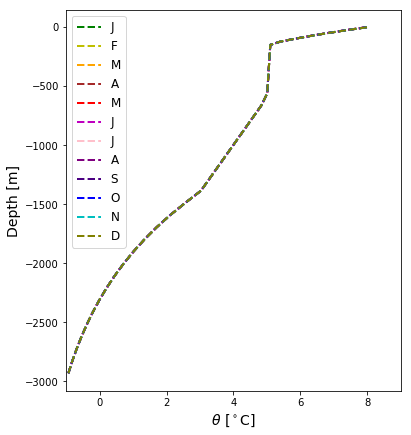

In [42]:
month = ['J','F','M','A','M','J','J','A','S','O','N','D']
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']

fig, ax = plt.subplots(figsize=(6,7))
for i in range(12):
    ax.plot(temp_north[i,:], zaxis[:], '--',
             label=month[i], color=colors[i], lw=2)

ax.set_xlim([-1,9])
ax.legend(loc='upper left', fontsize=12)
ax.set_xlabel(r"$\theta$ [$^\circ$C]", fontsize=14)
ax.set_ylabel(r"Depth [m]", fontsize=14)

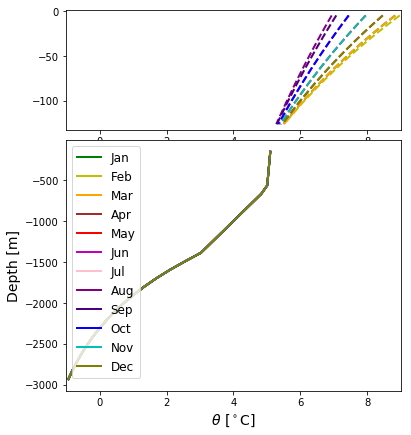

In [51]:
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']
month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
npl = 9

fig = plt.figure(figsize=(6,7))
gs = gridspec.GridSpec(nrows=6,ncols=1)
ax1 = plt.subplot(gs[:2])
ax2 = plt.subplot(gs[2:])
for i in range(12):
    ax1.plot(temp_north[i,:npl], zaxis[:npl], '--',
             label=month[i], color=colors[i], lw=2)
    ax2.plot(temp_north[i,npl:], zaxis[npl:], 
            label=month[i], color=colors[i], lw=2)

ax1.set_xlim([-1,9])
ax2.set_xlim([-1,9])
ax2.legend(loc='upper left', fontsize=12)
ax2.set_xlabel(r"$\theta$ [$^\circ$C]", fontsize=14)
ax2.set_ylabel(r"Depth [m]", fontsize=14)

In [145]:
print(temp_north[7])
print(np.diff(temp_north[7]))

[ 8.          8.00217617  8.00435234  8.00674613  8.00957515  8.0128394
  8.0166477   8.02110885  8.02633166  8.03242494  8.0396063   8.02732283
  8.01283465  7.99551181  7.97472441  7.9691511   7.62925467  7.25664094
  6.88220959  6.50777823  6.13334687  5.75891552  5.38448416  5.0100528
  4.63562145  4.26119009  3.88675873  3.51232738  3.13789602  2.76346466
  2.38903331  2.01460195  1.64017059  1.26573924  0.89130788  0.51687652
  0.14244517 -0.23198619 -0.60641755 -0.9808489 ]
[ 0.00217617  0.00217617  0.00239379  0.00282902  0.00326426  0.0038083
  0.00446115  0.00522281  0.00609328  0.00718136 -0.01228346 -0.01448819
 -0.01732283 -0.0207874  -0.00557331 -0.33989643 -0.37261373 -0.37443136
 -0.37443136 -0.37443136 -0.37443136 -0.37443136 -0.37443136 -0.37443136
 -0.37443136 -0.37443136 -0.37443136 -0.37443136 -0.37443136 -0.37443136
 -0.37443136 -0.37443136 -0.37443136 -0.37443136 -0.37443136 -0.37443136
 -0.37443136 -0.37443136 -0.37443136]


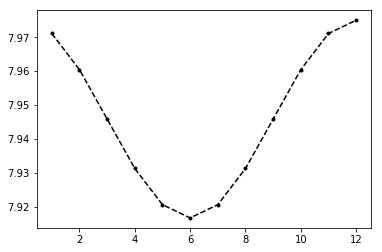

In [99]:
fig, ax = plt.subplots()
ax.plot(range(1,13),sst[:,-1],'k--')
ax.plot(range(1,13),temp_north[:,0], 'k.')

In [15]:
# temp_relax_large_analytical = np.tile(Tstar, (100,200,1)).T
# temp_relax_large_analytical.shape
ds = xr.open_dataset(op.join(ddir, 'BSOSE_rotated_northernboundary-temperature.nc'))
ds

<xarray.Dataset>
Dimensions:      (depth: 52, month: 12)
Coordinates:
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * depth        (depth) float64 -2.1 -6.7 -12.15 -18.55 -26.25 -35.25 -45.0 ...
Data variables:
    north_Theta  (month, depth) float64 ...

In [17]:
theta = ds.north_Theta
temp_relax = np.zeros((12,len(zaxis)))
z = np.absolute(theta.depth)
for i in range(12):
    f = intp.interp1d(np.absolute(z), theta[i])
    temp_relax[i] = f(np.absolute(zaxis))
temp_relax = xr.DataArray(theta_intp, dims=['month','z'],
                         coords={'month':range(12),'z':zaxis})
temp_relax[:,:15].plot(x='month')

NameError: name 'ds' is not defined

In [25]:
temp_relax.T

<xarray.DataArray (z: 40, month: 12)>
array([[ 12.055796,  12.743659,  12.544059, ...,   9.433958,  10.236496,
         11.198827],
       [ 11.977595,  12.613922,  12.521257, ...,   9.407937,  10.171553,
         11.103379],
       [ 11.836684,  12.41847 ,  12.480182, ...,   9.380547,  10.086563,
         10.970031],
       ..., 
       [  1.666772,   1.670292,   1.673586, ...,   1.670409,   1.671176,
          1.672414],
       [  1.584892,   1.58848 ,   1.59179 , ...,   1.589256,   1.59015 ,
          1.591536],
       [  1.503013,   1.506667,   1.509994, ...,   1.508103,   1.509124,
          1.510658]])
Coordinates:
  * month    (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * z        (z) float64 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...

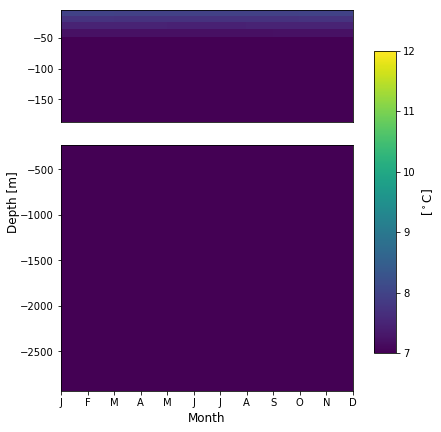

In [43]:
nz = 11
fig = plt.figure(figsize=(6,7))
gs = gridspec.GridSpec(ncols=1, nrows=3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1:,0])
cax = ax1.pcolormesh(range(12), zaxis[:nz], temp_north.T[:nz,:], 
                     vmin=7., vmax=12, rasterized=True)
ax2.pcolormesh(range(12), zaxis[nz:], temp_north.T[nz:,:], 
               vmin=7., vmax=12, rasterized=True)
ax1.set_xticks([])
ax2.set_xticks(range(12))
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax2.set_xlabel('Month', fontsize=12)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.6])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r'[$^\circ$C]',fontsize=12)
fig.text(0, 0.5, 'Depth [m]', 
         va='center', rotation='vertical', fontsize=12)
# plt.savefig('NorthTempRelax_Seasonality.pdf')

In [44]:
# print((temp_north[:,:,np.newaxis,np.newaxis]*np.ones((ny,nx))).shape)
# (temp_north[:,:,np.newaxis,np.newaxis]*np.ones((ny,nx))).astype(tp).tofile(output_dir 
#                                                             + 'rbcs_temp-seasonal-relax_change-of-slope_%03dkm.bin' 
#                                                             % res)

(12, 40, 400, 200)


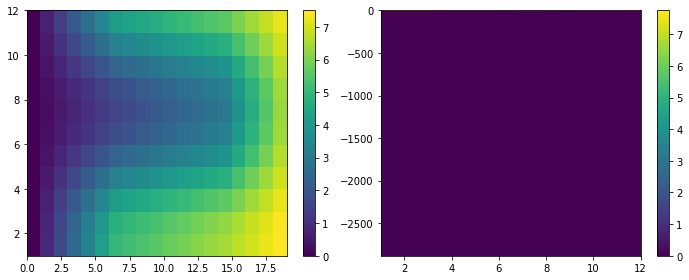

In [31]:
rbcs_temp = np.zeros((12,nz,ny,nx))
rbcs_temp[:,0] = sst[:,:,np.newaxis]*np.ones(nx)
# rbcs_temp[:,1:] = temp_north[:,1:,np.newaxis,np.newaxis]*np.ones((ny,nx))

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.set_tight_layout(True)
im1 = ax1.pcolormesh(range(ny), range(1,13), rbcs_temp[:,0].mean(axis=-1))
im2 = ax2.pcolormesh(range(1,13), zaxis, rbcs_temp[:,:,-1].mean(axis=-1).T)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

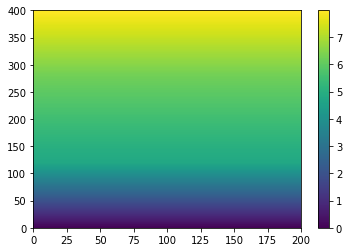

In [27]:
plt.pcolormesh(rbcs_temp[0,0])
plt.colorbar()

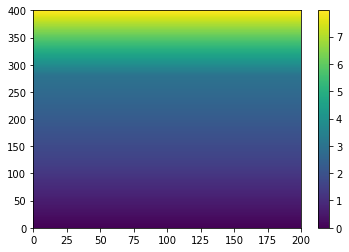

In [29]:
plt.pcolormesh(rbcs_temp[5,0])
plt.colorbar()

In [32]:
print(rbcs_temp.shape)
rbcs_temp.astype(tp).tofile(output_dir 
                           + 'rbcs_SSTandNB-relax_zero-res_-2mon_%03dkm.bin'
                           % res)

(12, 40, 20, 10)


/rigel/home/tu2140/miniconda3/envs/pangeo/lib/python3.7/site-packages/xmitgcm-0.2.2-py3.7.egg/xmitgcm/utils.py:429: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


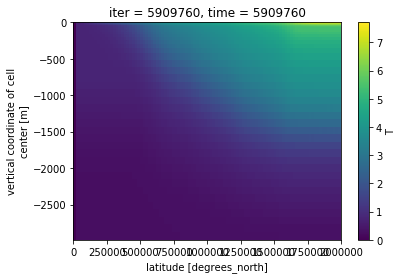

In [34]:
ds = open_mdsdataset('/rigel/ocp/users/tu2140/chkp63n/MITgcm/Southern-Ocean/channel_flat/runs/withBIO/zero-res_20km_1000GMRedi_02kmMLI',
                    iters='5909760',
                    prefix=['T'])
ds['T'].mean('XC').plot()

In [41]:
ds['T']

<xarray.DataArray 'T' (time: 1, Z: 40, YC: 100, XC: 50)>
dask.array<shape=(1, 40, 100, 50), dtype=>f4, chunksize=(1, 40, 100, 50)>
Coordinates:
    iter     (time) int64 5909760
  * time     (time) int64 5909760
  * XC       (XC) >f4 10000.0 30000.0 50000.0 ... 950000.0 970000.0 990000.0
  * YC       (YC) >f4 10000.0 30000.0 50000.0 ... 1950000.0 1970000.0 1990000.0
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
    rA       (YC, XC) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    Depth    (YC, XC) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    drF      (Z) >f4 10.0 10.0 10.0 12.0 14.0 ... 103.0 103.0 103.0 103.0 103.0
    PHrefC   (Z) >f4 49.05 147.15 245.25 ... 26756.775 27767.205 28777.635
    hFacC    (Z, YC, XC) >f4 dask.array<shape=(40, 100, 50), chunksize=(40, 100, 50)>
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Potential Temperature
    units:          degree_Celcius

In [46]:
len(dzlow)

40

In [48]:
# temp_init = ds.Theta_timeandzonclim.data[:,:,np.newaxis] * np.ones(nx)[np.newaxis,np.newaxis,:]
# temp_init[temp_init<1] = 1.
# a = 3e3**-1 * (np.log(11) - np.log(2))
# temp_init = 11.*np.exp(a*zaxis) - 3.
# plt.plot(temp_init,zaxis)
# temp_init = temp_init[:,np.newaxis,np.newaxis] * np.ones((ny,nx))[np.newaxis,:,:]
# N = temp_init.shape
# temp_init += np.random.randn(N[0],N[1],N[2])
from scipy.interpolate import interpn
ynew = np.arange(0,2000,res)
xnew = np.arange(0,1000,res)
temp_init = np.empty((len(dzlow),len(ynew),len(xnew)))
for i in range(len(dzlow)):
    f = interp2d(ds.XC.data*1e-3, ds.YC.data*1e-3, ds['T'][0,i].data)
    temp_init[i] = f(xnew,ynew)
# temp_init += 1e-5*np.random.randn(temp_init.shape[0],
#                             temp_init.shape[1],
#                             temp_init.shape[2])
# temp_init = temp_relax_large_analytical + np.random.randn(temp_relax_large_analytical.shape[0],
#                                                          temp_relax_large_analytical.shape[1],
#                                                          temp_relax_large_analytical.shape[2])
temp_init

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.93785957, 0.93805955, 0.93785396, ..., 0.93588911,
         0.93643451, 0.93716386],
        [1.40435844, 1.40494951, 1.40528914, ..., 1.40382328,
         1.40363743, 1.40377706],
        ...,
        [6.55599817, 6.57652954, 6.58946306, ..., 6.5742598 ,
         6.55974982, 6.55121131],
        [6.99817129, 7.00089047, 7.00087892, ..., 6.99562273,
         6.99325761, 6.99359902],
        [7.44519069, 7.44040043, 7.44078643, ..., 7.44245642,
         7.44141669, 7.44086617]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.93072829, 0.93092132, 0.93070376, ..., 0.92873488,
         0.92929219, 0.93003106],
        [1.38596248, 1.38653498, 1.38684975, ..., 1.38541146,
         1.38524135, 1.38539129],
        ...,
        [6.53616054, 6.55918603, 6.572949  , ..., 6.5566235 ,
         6.54022691, 6.53110952],
        [6.9

In [34]:
nn = np.argmin(np.abs(temp_init.ravel()))
temp_init.ravel()[nn]

-1.967152628736119e-09

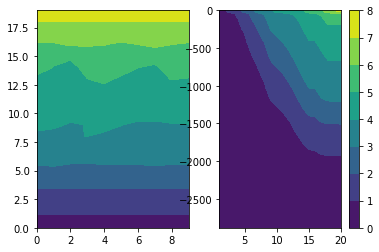

In [49]:
plt.figure()

plt.subplot(121)
plt.contourf(temp_init[0,:,:])

plt.subplot(122)
plt.contourf(range(1,ny+1),zaxis,temp_init[:,:,0])

plt.colorbar()

In [50]:
print(temp_init.shape)
temp_init.astype(tp).tofile(output_dir + 'THETA_init_from-zero-res_-2mondeeplocalML_%03dkm.bin' % res)

(40, 20, 10)


In [51]:
mask = np.zeros((ny,nx))
# mask[-10:] += np.linspace(0.,1.,num=10)[:,np.newaxis] * np.ones((10,nx))
rbcs_mask = np.tile(mask,(nz,1,1))
rbcs_mask[0] = 1.
rbcs_mask.shape

(40, 20, 10)

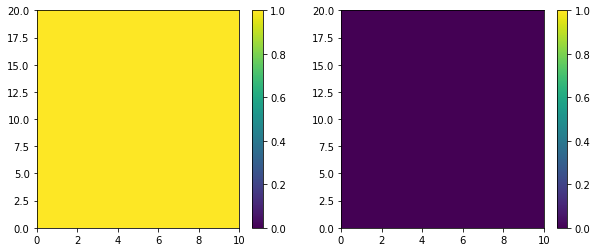

In [52]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
im1 = ax1.pcolormesh(rbcs_mask[0],vmin=0.,vmax=1.)
im2 = ax2.pcolormesh(rbcs_mask[1],vmin=0.,vmax=1.)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [77]:
rbcs_mask.astype(tp).tofile(output_dir + 'rbcs_SSTandNB_relax_mask_zero-res_%03dkm.bin' % res)

In [19]:
mask = np.zeros((ny,nx))
nN = int(1e2/res)
nS = int(2e2/res)
if nN>1:
    mask[-nN:] += np.linspace(0.,1.,num=nN)[:,np.newaxis] * np.ones(nx)[np.newaxis,:]
else:
    mask[-1] = 1.
# mask[:nS] += np.linspace(1.,0.,num=nS)[:,np.newaxis] * np.ones(nx)[np.newaxis,:]
nut_mask = np.tile(mask,(nz,1,1))
# nut_mask[0] = np.linspace(0.,1.,num=ny)[:,np.newaxis] * np.ones(nx)[np.newaxis,:]
nut_mask.shape

(40, 20, 10)

In [22]:
nut_mask[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

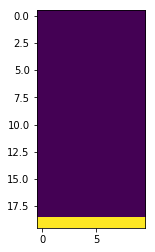

In [24]:
plt.imshow(nut_mask[0])

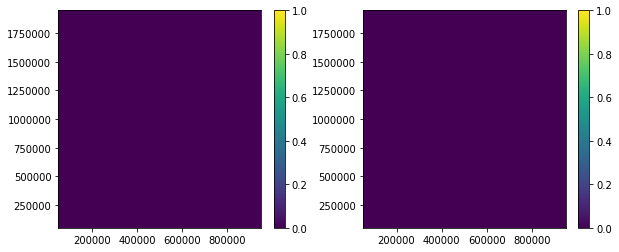

In [23]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
im1 = ax1.pcolormesh(xc,yc,nut_mask[0],vmin=0.,vmax=1.)
im2 = ax2.pcolormesh(xc,yc,nut_mask[1],vmin=0.,vmax=1.)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [26]:
print(nut_mask.shape)
nut_mask.astype(tp).tofile('/swot/SUM02/takaya/channelMOC-Darwin/rbcs_nut_relax_mask_zero-res_NoSB_%03dkm.bin' % res)

(40, 20, 10)


In [38]:
(np.cumsum(dzhigh)-.5)[27:40]
# dzlow

array([ 198.75,  218.72,  239.99,  262.55,  286.42,  311.59,  338.05,
        365.79,  394.79,  425.03,  456.48,  489.13,  522.95])

In [107]:
zzlow = np.cumsum(dzlow)-5.
zzhigh = np.cumsum(dzhigh)-.5
nz20 = (10,17)
nz05 = (27,41)
if nz == 40:
    zz = zzlow
    nzsyn = nz20
elif nz == 76:
    zz = zzhigh
    nzsyn = nz05

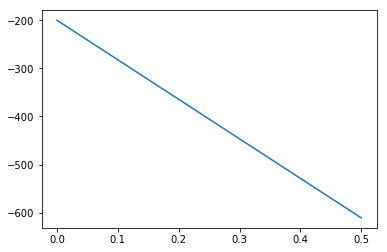

In [108]:
tmp = zz[nzsyn[0]:nzsyn[1]]*0.5/(zz[nzsyn[1]-1]-zz[nzsyn[0]])
tmp -= tmp[0]
# tmp += 0.01
plt.plot(tmp,-zz[nzsyn[0]:nzsyn[1]])

In [113]:
tmp

array([ 0.        ,  0.05109489,  0.11192214,  0.18491484,  0.27250608,
        0.37591241,  0.5       ])

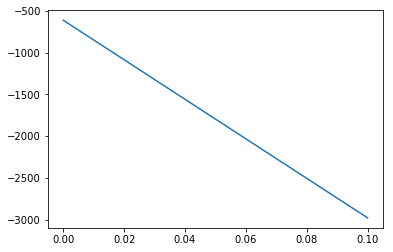

In [109]:
tmp2 = zz[nzsyn[1]-1:]*(.6-tmp[-1])/(zz[-1]-zz[nzsyn[1]-1])
tmp2 -= tmp2[0]
# tmp2 += tmp[-1]
plt.plot(tmp2,-zz[nzsyn[1]-1:])

In [114]:
tmp2

array([ 0.        ,  0.00434783,  0.00869565,  0.01304348,  0.0173913 ,
        0.02173913,  0.02608696,  0.03043478,  0.03478261,  0.03913043,
        0.04347826,  0.04782609,  0.05217391,  0.05652174,  0.06086957,
        0.06521739,  0.06956522,  0.07391304,  0.07826087,  0.0826087 ,
        0.08695652,  0.09130435,  0.09565217,  0.1       ])

In [110]:
ptr_relax = np.zeros((nz,ny,nx))
# ptr_relax[:11] = (zz[:11]*0.01/195-0.01/39)[:,np.newaxis,np.newaxis] * np.ones((ny,nx))[np.newaxis,:,:]
ptr_relax[nzsyn[0]:nzsyn[1]] = tmp[:,np.newaxis,np.newaxis] * np.ones((ny,nx))[np.newaxis,:,:]
ptr_relax[nzsyn[1]-1:] = (tmp[-1]+tmp2)[:,np.newaxis,np.newaxis] * np.ones((ny,nx))[np.newaxis,:,:]
ptr_relax[0] = 0.
ptr_relax *= 1e-3

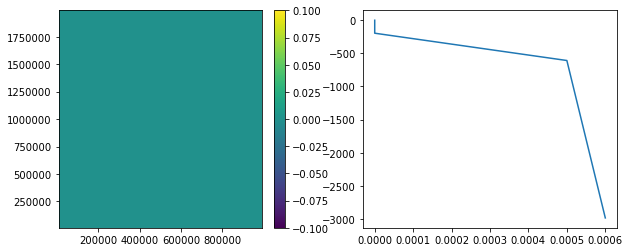

In [111]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
im1 = ax1.pcolormesh(xc,yc,ptr_relax[0])
im2 = ax2.plot(ptr_relax[:,0,0],-zz)
fig.colorbar(im1, ax=ax1)
# fig.colorbar(im2, ax=ax2)

In [112]:
print(ptr_relax.shape)
ptr_relax.astype(tp).tofile(output_dir + 'rbcs_nut_relax_zero-res_1PTR_%03dkm.bin' % res)

(40, 100, 50)


# Nutrient intial conditions

In [40]:
fe = xr.open_dataarray('BSOSE_Fe-transect-climatology.nc')
fe

<xarray.DataArray (depth: 45, lat: 108)>
array([[ 0.000218,  0.000218,  0.000217, ...,  0.000124,  0.000124,  0.000123],
       [ 0.000218,  0.000218,  0.000217, ...,  0.000124,  0.000124,  0.000123],
       [ 0.000219,  0.000218,  0.000217, ...,  0.000124,  0.000124,  0.000123],
       ..., 
       [ 0.000342,  0.000341,  0.000342, ...,  0.00032 ,  0.000321,  0.000322],
       [ 0.000331,  0.000331,  0.000331, ...,  0.000312,  0.000313,  0.000313],
       [ 0.000319,  0.000318,  0.000318, ...,  0.000302,  0.000302,  0.000303]])
Coordinates:
  * depth    (depth) float64 -2.1 -6.7 -12.15 -18.55 -26.25 -35.25 -45.0 ...
  * lat      (lat) float64 -64.97 -64.83 -64.69 -64.54 -64.4 -64.26 -64.11 ...

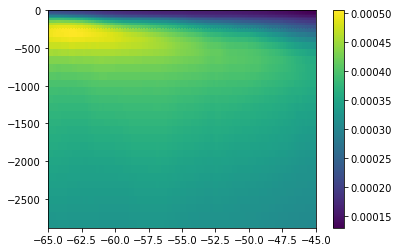

In [42]:
z = np.absolute(fe.depth)
ys = range(len(fe.lat))
f = intp.interp2d(ys, z, fe)
fe_intp = f(range(ny), np.absolute(zaxis))

plt.pcolormesh(np.linspace(-65,-45,num=ny),zaxis,fe_intp)
plt.colorbar()

In [43]:
(fe_intp[:,:,np.newaxis]*np.ones(nx)).astype(tp).tofile(output_dir 
                                                        + 'fet_init_latdependency_%03dkm.bin' % res)

In [44]:
ds = xr.open_dataset(op.join(ddir, 'WOA_annualclimatology.nc'))
ds

<xarray.Dataset>
Dimensions:  (depth: 33, lat: 40, lon: 360)
Coordinates:
  * lat      (lat) float32 -79.5 -78.5 -77.5 -76.5 -75.5 -74.5 -73.5 -72.5 ...
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * depth    (depth) float32 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 150.0 ...
    time     datetime64[ns] ...
Data variables:
    t_an     (depth, lat, lon) float32 ...
    s_an     (depth, lat, lon) float32 ...
    p_an     (depth, lat, lon) float32 ...
    n_an     (depth, lat, lon) float32 ...
    i_an     (depth, lat, lon) float32 ...
    t_dd     (depth, lat, lon) float64 ...
    basin    (depth, lat, lon) float32 ...
    pres     (depth, lat) float64 ...
    SA       (depth, lat, lon) float64 ...
    CT       (depth, lat, lon) float64 ...
    sig0     (depth, lat, lon) float64 ...

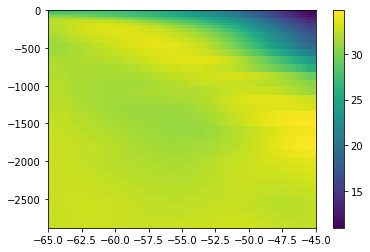

In [45]:
# no3 = xr.open_dataarray('BSOSE_NO3-transect-climatology.nc')
no3 = ds.n_an.sel(lon=slice(100,130),lat=slice(-65,-45),depth=slice(0,3000)).mean('lon')
z = np.absolute(no3.depth)
ys = no3.lat
f = intp.interp2d(ys, z, no3)
no3_intp = f(np.linspace(-65,-45,num=ny), np.absolute(zaxis))

plt.pcolormesh(np.linspace(-65,-45,num=ny),zaxis,no3_intp)
plt.colorbar()

In [17]:

no3

<xarray.DataArray (depth: 45, lat: 108)>
array([[ 27.598925,  27.58842 ,  27.572538, ...,  16.032441,  15.772613,
         15.508236],
       [ 27.600588,  27.590066,  27.574174, ...,  16.033099,  15.773313,
         15.508956],
       [ 27.609672,  27.598932,  27.582971, ...,  16.035401,  15.776037,
         15.51182 ],
       ..., 
       [ 32.642044,  32.651599,  32.650472, ...,  32.346644,  32.301136,
         32.258563],
       [ 32.657578,  32.664789,  32.664115, ...,  32.001323,  31.939346,
         31.875795],
       [ 32.676714,  32.690285,  32.692034, ...,  31.927572,  31.878   ,
         31.815477]])
Coordinates:
  * depth    (depth) float64 -2.1 -6.7 -12.15 -18.55 -26.25 -35.25 -45.0 ...
  * lat      (lat) float64 -64.97 -64.83 -64.69 -64.54 -64.4 -64.26 -64.11 ...

In [46]:
print((no3_intp[:,:,np.newaxis]*np.ones(nx)).shape)
(no3_intp[:,:,np.newaxis]*np.ones(nx)).astype(tp).tofile(output_dir 
                                                         + 'no3_init_woa_%03dkm.bin' % res)

(40, 100, 50)


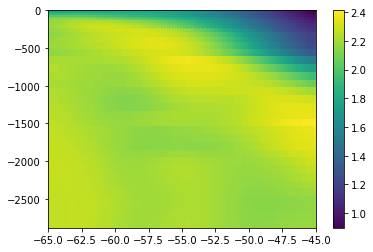

In [47]:
# po4 = xr.open_dataarray('BSOSE_PO4-transect-climatology.nc')
po4 = ds.p_an.sel(lon=slice(100,130),lat=slice(-65,-45),depth=slice(0,3000)).mean('lon')
z = np.absolute(po4.depth)
ys = po4.lat
f = intp.interp2d(ys, z, po4)
po4_intp = f(np.linspace(-65,-45,num=ny), np.absolute(zaxis))

plt.pcolormesh(np.linspace(-65,-45,num=ny),zaxis,po4_intp)
plt.colorbar()

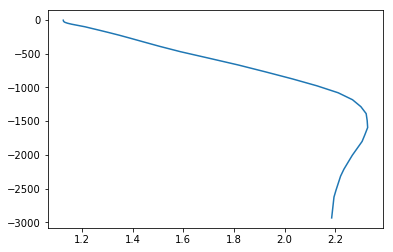

In [22]:
plt.plot(po4_intp[:,-1],zaxis)

In [48]:
print((po4_intp[:,:,np.newaxis]*np.ones(nx)).shape)
(po4_intp[:,:,np.newaxis]*np.ones(nx)).astype(tp).tofile(output_dir 
                                                         + 'po4_init_woa_%03dkm.bin' % res)

(40, 100, 50)


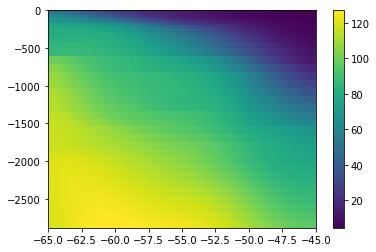

In [49]:
# sio2 = xr.open_dataarray('WOA5deg_SiO2-transect-climatology.nc')
sio2 = ds.i_an.sel(lon=slice(100,130), lat=slice(-65,-45), depth=slice(0,3000)).mean('lon')
z = np.absolute(sio2.depth)
ys = sio2.lat
f = intp.interp2d(ys, z, sio2)
sio2_intp = f(np.linspace(-65,-45,num=ny), np.absolute(zaxis))

plt.pcolormesh(np.linspace(-65,-45,num=ny), zaxis, sio2_intp)
plt.colorbar()

In [50]:
print((sio2_intp[:,:,np.newaxis]*np.ones(nx)).shape)
(sio2_intp[:,:,np.newaxis]*np.ones(nx)).astype(tp).tofile(output_dir 
                                                         + 'sio2_init_woa_%03dkm.bin' % res)

(40, 100, 50)


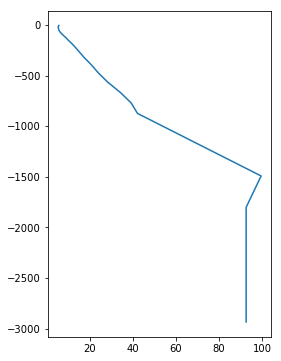

In [20]:
sio2_relax = sio2_intp[:,-1].copy()
sio2_relax[19:26] = np.linspace(sio2_intp[19,-1],sio2_intp.max(),7)
sio2_relax[25:29] = np.linspace(sio2_intp.max(),sio2_intp[15,0],4)
sio2_relax[29:] = sio2_intp[15,0]

plt.figure(figsize=(4,6))
plt.plot(sio2_relax,zaxis)

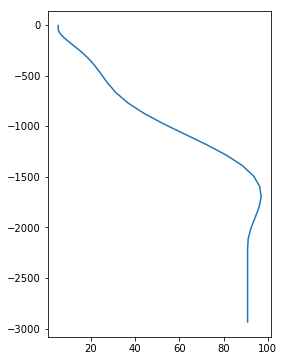

In [35]:
p4 = np.poly1d(np.polyfit(zaxis, sio2_relax, deg=9))
sio2_relax_intp = p4(zaxis)
nmin = np.argmin(sio2_relax_intp)
sio2_relax_intp[:nmin] = sio2_relax_intp.min()
loclmin = np.argmin(sio2_relax_intp[30:35])
sio2_relax_intp[30+loclmin:] = sio2_relax_intp[30:35].min()

plt.figure(figsize=(4,6))
plt.plot(sio2_relax_intp,zaxis)

In [33]:
zaxis

array([   -5. ,   -15. ,   -25. ,   -36. ,   -49. ,   -64. ,   -81.5,
        -102. ,  -126. ,  -154. ,  -187. ,  -226. ,  -272. ,  -327. ,
        -393. ,  -471.5,  -565. ,  -667.5,  -770.5,  -873.5,  -976.5,
       -1079.5, -1182.5, -1285.5, -1388.5, -1491.5, -1594.5, -1697.5,
       -1800.5, -1903.5, -2006.5, -2109.5, -2212.5, -2315.5, -2418.5,
       -2521.5, -2624.5, -2727.5, -2830.5, -2933.5])

In [24]:
3e0*86400

259200.0

In [27]:
86400*30/1e1

259200.0